<a href="https://colab.research.google.com/github/khodid/2021MachineLearningIntro/blob/main/Ch5_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 이론
교재: 파이썬 머신러닝 완벽 가이드 (권철민 저) 
날짜: 2021년 6월 2일

## 05장:회귀 이론

- 선형 회귀: feature의 선형 결합
 - feature들을 그대로 선형 결합을 하는 방법
 - **다항회귀**: feature의 곱, 자승을 새로운 변수로 생각해 선형 결합  
   (데이터의 분포가 1차 방정식 형태가 아닐 때)
 - **규제**: overfitting 방지. 다항회귀 차수가 낮으면 underfitting 위험, 높으면 overfitting 위험
   - **L1규제(라쏘):** 안 중요한 feature의 계수를 0으로 수렴시켜서 회귀 feature 수를 줄임
   - **L2규제(릿지):** 전체적인 회귀 계수의 값이 너무 커지지 않도록 만듦
   - 둘 다 쓴 건 Elastic Net
 - 데이터 전처리:
   - StandardScaler, MinMaxScaler 이용
   - 다항 변환
   - **Log Transformation**: 제일 많이 쓰임. 정규 분포에 가깝게 값이 변환됨
- 비선형 회귀: Decision Tree를 이용한 회귀 기법
 - 분류에서 썼던 랜포, GBM, XGBoost, LGBM 모두 회귀 가능.
 - 노드의 평균 값을 이용한다.

# 실습
- 데이터: [Kaggle의 Electric Motor Temperature](https://www.kaggle.com/wkirgsn/electric-motor-temperature) 대회 데이터셋
 - 초당 2회씩 측정된 데이터
 - profile_id는 측정 세션
- 해볼 것들:
 - 규제 가중치(알파) 변화에 따른 결과 관찰
 - log 변환 여부에 따른 결과 관찰

## 데이터 살펴보기

In [ ]:
import numpy as np
import pandas as pd

# 데이터 받아오기
df = pd.read_csv('measures_v2.csv')

In [ ]:
# 데이터 feature 확인
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17.0
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17.0
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17.0
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17.0
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17.0


In [ ]:
# data 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55958 entries, 0 to 55957
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   u_q             55958 non-null  float64
 1   coolant         55958 non-null  float64
 2   stator_winding  55958 non-null  float64
 3   u_d             55958 non-null  float64
 4   stator_tooth    55958 non-null  float64
 5   motor_speed     55958 non-null  float64
 6   i_d             55958 non-null  float64
 7   i_q             55958 non-null  float64
 8   pm              55958 non-null  float64
 9   stator_yoke     55958 non-null  float64
 10  ambient         55958 non-null  float64
 11  torque          55957 non-null  float64
 12  profile_id      55957 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB


In [ ]:
# 총 10개의 feature를 갖고 전부 숫자형이다.
# 대회 설명에 의하면 예측 목표는 stator_yoke, stator_winding, stator_tooth, pm 이라고 함
# 일단 pm만 예측해보도록 하겠음
# 대회 Loss는 MSE(mean square error)

In [ ]:
# 기초통계 확인
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,55958.000000,55958.000000,55958.000000,55958.000000,55958.000000,55958.000000,55958.000000,55958.000000,55958.000000,55958.000000,55958.000000,55957.000000,55957.000000
mean,81.062490,18.761282,45.225936,-46.163591,38.478354,2619.311954,-57.356530,61.900490,44.135580,30.672959,23.142891,49.487562,12.742785
std,28.428043,0.481206,19.514987,43.265603,13.303306,1576.816394,54.743589,62.255672,12.515000,7.959326,1.233369,50.505359,6.546434
min,-0.974433,17.123543,19.049341,-129.973694,18.268650,-0.006299,-215.383972,-0.000785,21.213623,18.076689,18.613419,-0.932627,5.000000
25%,49.985188,18.399132,25.628489,-85.321972,25.935953,999.998352,-97.425367,1.096966,33.366082,23.444660,23.147494,-0.083731,5.000000
50%,83.510822,18.692594,48.559818,-43.015301,39.452286,1999.979614,-43.511662,53.342249,42.394621,32.466997,23.289569,48.499104,12.000000
75%,97.023169,19.129102,49.835812,-0.552212,43.231446,4999.944824,-2.001413,132.617325,52.223005,33.611387,23.534884,101.861801,17.000000
max,131.331100,21.393656,119.306381,2.676198,84.370834,4999.971191,0.004419,193.912521,71.661995,58.322124,25.875355,183.115402,32.000000


In [ ]:
import seaborn as sns

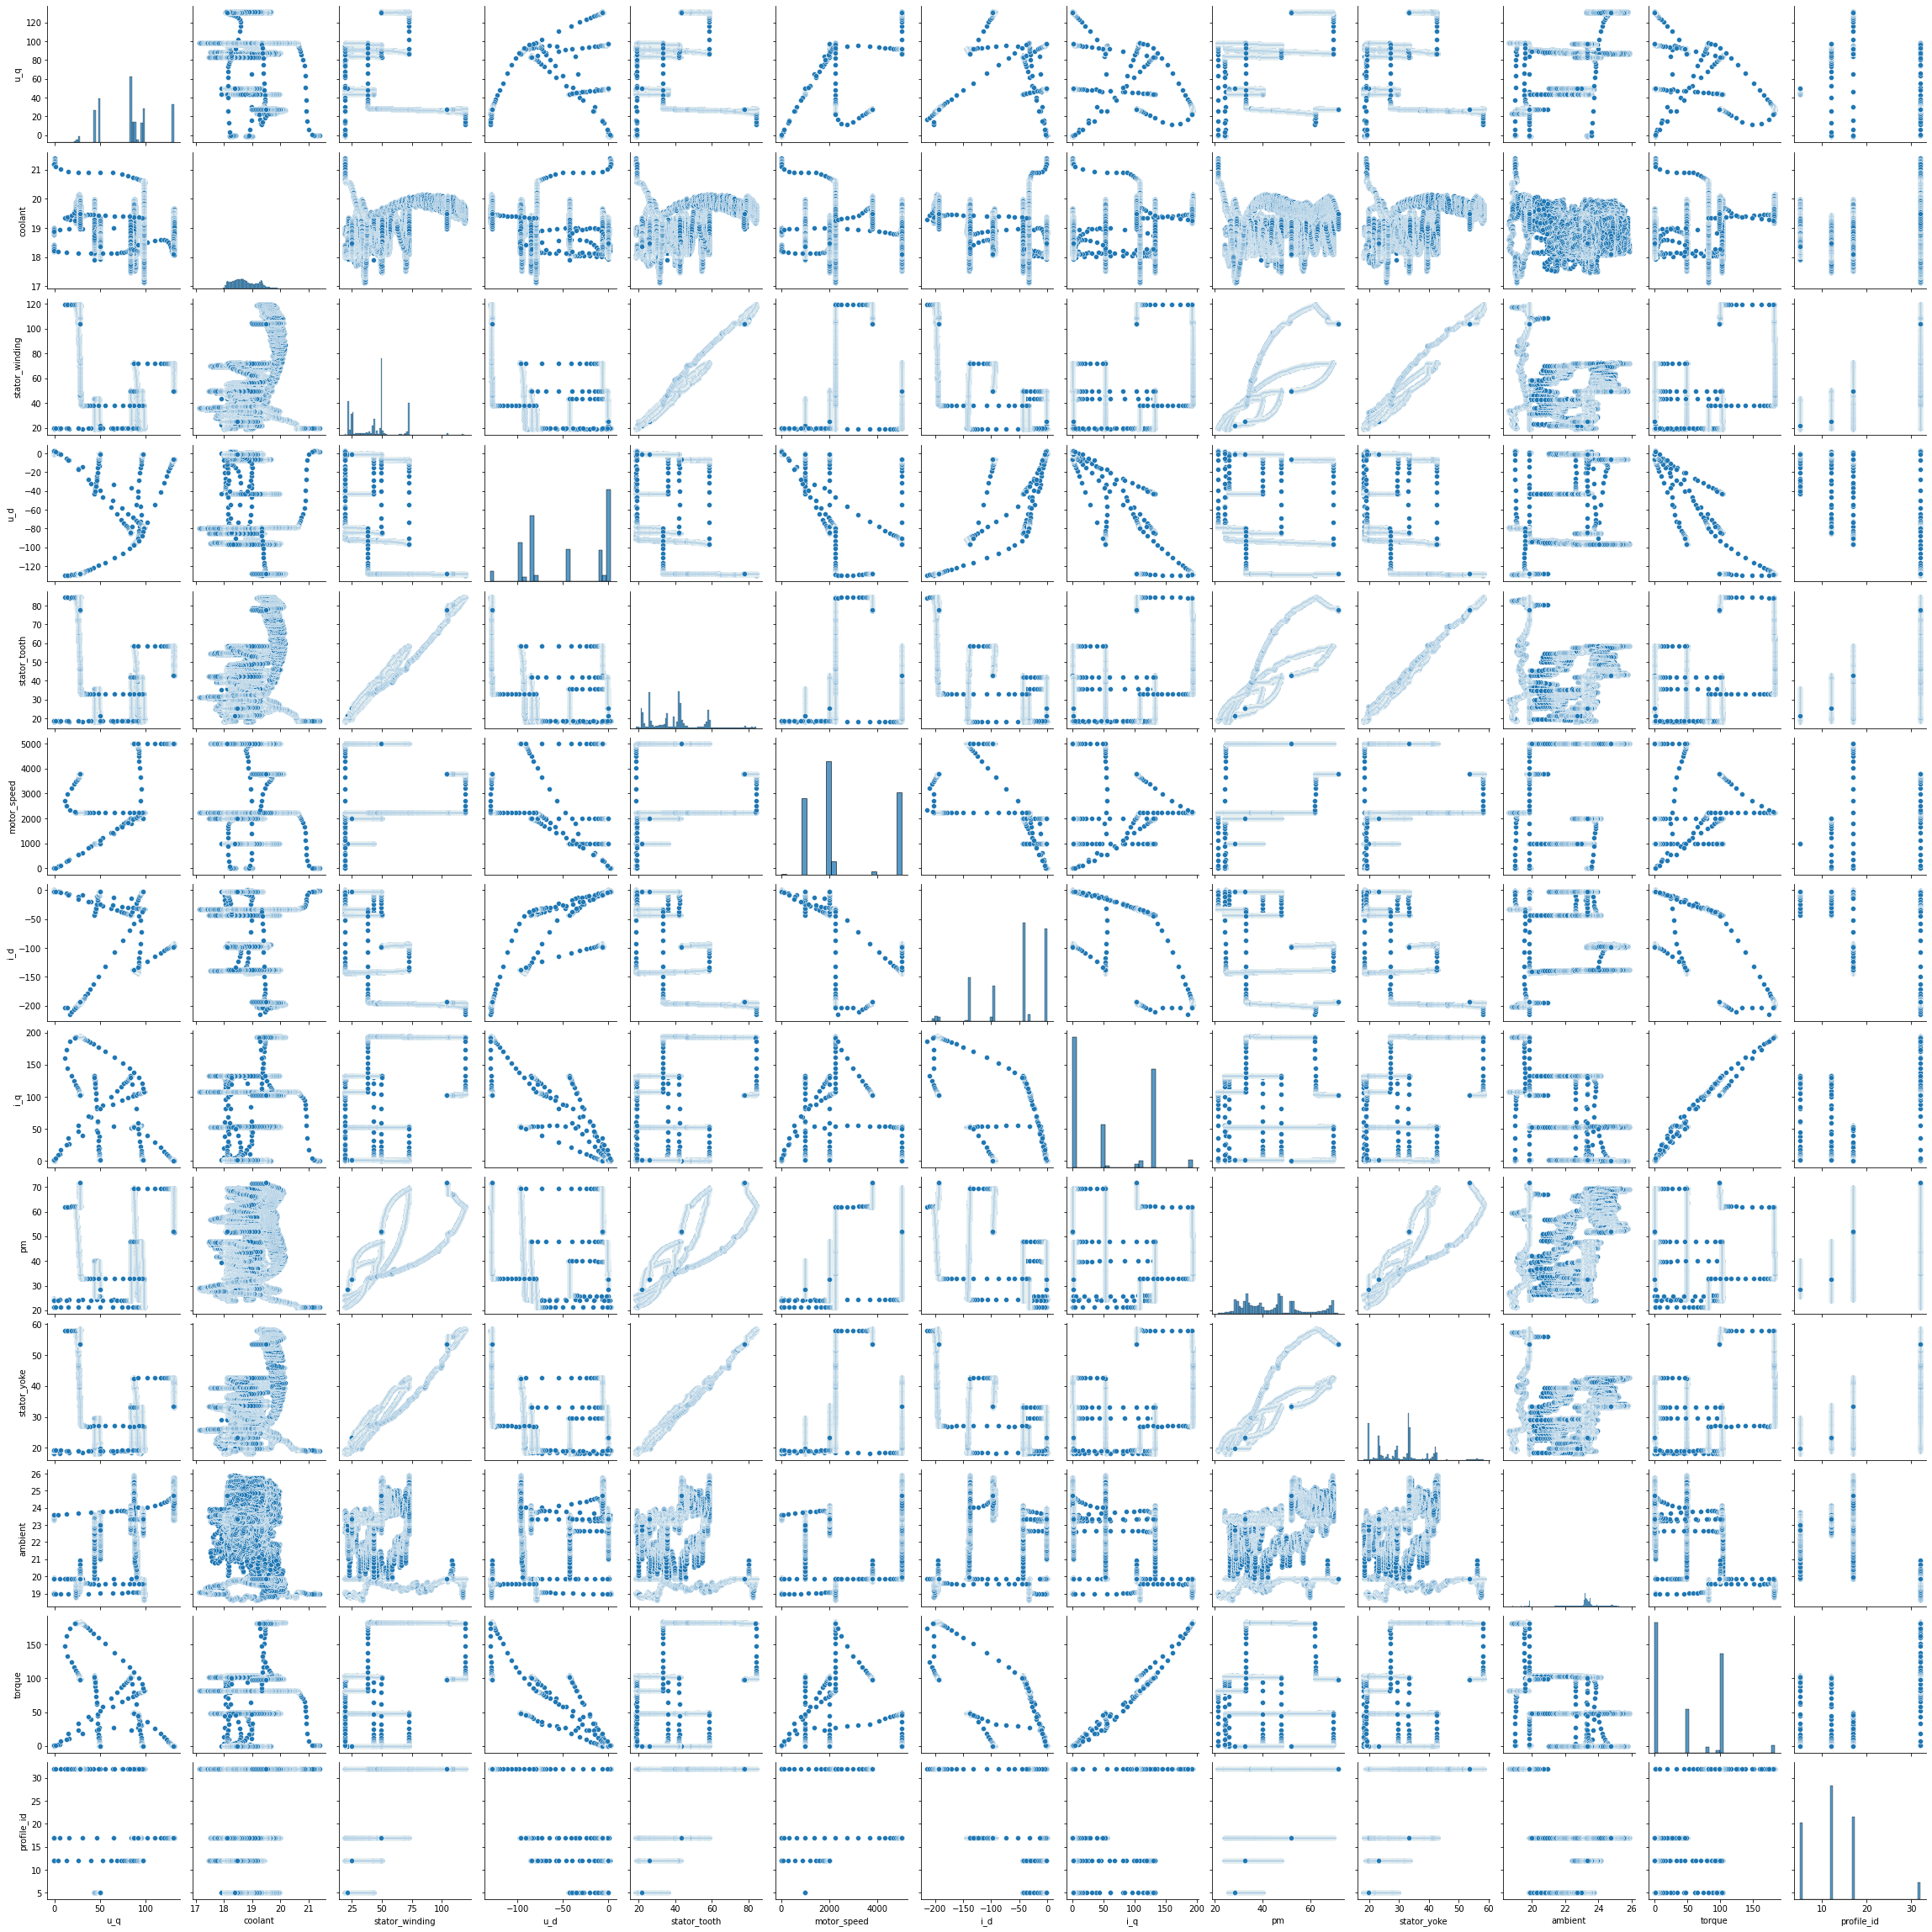

In [ ]:
# 모든 feature 간의 scatterplot을 그려주는
sns.pairplot(df)

데이터 분포가 굉장히.. 신기하다. 그와중에 선형 관계를 띄는 것들도 몇몇 있다.
예를 들면 stator_yoke와 stator_winding, stator_tooth, pm... 얘네는 서로 선형인데 다 예측 대상이 되는 feature들임

In [ ]:
df.columns

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')

아까 찾았던 null값 처리

In [ ]:
df.dropna(inplace=True)

In [ ]:
X = df.loc[:][['u_q', 'coolant', 'u_d','motor_speed', 'i_d', 'i_q','ambient', 'torque','profile_id']]
y = df.loc[:]['pm']

In [ ]:
print(X.shape)
print(y.shape)

(55957, 9)
(55957,)


# Backbone(?)
모델 실험을 위한 탬플릿

In [ ]:
from sklearn.preprocessing import StandardScaler
S = StandardScaler().fit(X)
X_scaled = S.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X_scaled, y, test_size = 0.2)

In [ ]:
# 모델 선언과 예측

from sklearn.linear_model import LinearRegression
linmodel = LinearRegression()
linmodel.fit(X_train, y_train)

train_pred = linmodel.predict(X_train)
val_pred = linmodel.predict(X_test)

In [ ]:
# 회귀계수 확인
linmodel.coef_

array([-5.30182362,  0.22220259, -2.588667  ,  8.82283523, -0.56507828,
        4.91713365,  6.27442008, -4.29339117,  3.29350519])

In [ ]:
# 모델 평가
from sklearn.metrics import mean_squared_error
print(f"train set MSE : {mean_squared_error(y_train, train_pred)}")
print(f"test  set MSE : {mean_squared_error(y_test, val_pred)}")

train set MSE : 20.399147991145796
test  set MSE : 20.364369439951407


## 실험1: 규제 alpha 값 실험
- 엘라스틱넷으로 릿지(l1\_ratio = 0), 라쏘(l1\_ratio=1) 실험해보기

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
alpha = [0.1, 1, 10]
l1_ratio = [0, 0.3, 0.5, 0.7, 1]

for i, a in enumerate(alpha):
    print("==============================================================")
    print(f"[ROUND {i}] 실험alpha 값은 {a}")
    print("==============================================================")
    for r in l1_ratio:
        model = ElasticNet(alpha=a, l1_ratio=r)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_test)
        print("==============================================================")
        print(f'L1 ratio가 {r}일 때 ...')
        print(f'- 회귀 계수는 {model.coef_}')
        print(f"- train set MSE : {mean_squared_error(y_train, train_pred)}")
        print(f"- test  set MSE : {mean_squared_error(y_test, val_pred)}")
    print("==============================================================")


[ROUND 0] 실험alpha 값은 0.1


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 641541.7677210445, tolerance: 704.1045575900237
  positive)


L1 ratio가 0일 때 ...
- 회귀 계수는 [-0.96138488  0.43675191 -3.32731671  3.84719775 -4.1513553  -0.38401153
  4.75896343 -0.16622526  1.16998878]
- train set MSE : 21.821406851807946
- test  set MSE : 22.014291572014788
L1 ratio가 0.3일 때 ...
- 회귀 계수는 [-1.0980178   0.38196595 -3.35989478  3.91548464 -4.20544247 -0.39337704
  4.91984061 -0.14510736  1.18786876]
- train set MSE : 21.55211080156244
- test  set MSE : 21.747657338917303
L1 ratio가 0.5일 때 ...
- 회귀 계수는 [-1.22117983  0.3404095  -3.37026079  3.9884764  -4.22197207 -0.39896849
  5.04383516 -0.11969633  1.21736234]
- train set MSE : 21.386662130187773
- test  set MSE : 21.580682343553185
L1 ratio가 0.7일 때 ...
- 회귀 계수는 [-1.39991067  0.29364248 -3.3591755   4.13044059 -4.18362385 -0.40560853
  5.18789026 -0.0641053   1.27516701]
- train set MSE : 21.230119725943197
- test  set MSE : 21.418014985807428
L1 ratio가 1일 때 ...
- 회귀 계수는 [-2.42514605  0.20343474 -3.09254358  5.55828706 -3.15131893 -0.
  5.50558975 -0.          1.68160943]
- train set 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1457534.5360500559, tolerance: 704.1045575900237
  positive)


L1 ratio가 0일 때 ...
- 회귀 계수는 [ 0.66994218  0.63178312 -1.86682263  2.80536249 -2.86127466  0.03509938
  2.28229885  0.20533191  1.00803449]
- train set MSE : 38.461015270142866
- test  set MSE : 37.99477807699603
L1 ratio가 0.3일 때 ...
- 회귀 계수는 [ 0.38458856  0.47237277 -2.03888213  3.05914044 -3.17553676  0.
  2.48229401  0.          0.89012927]
- train set MSE : 34.842759387517816
- test  set MSE : 34.55070164526451
L1 ratio가 0.5일 때 ...
- 회귀 계수는 [ 0.08526438  0.29273076 -2.08846071  3.3509578  -3.44505045  0.
  2.6837476   0.          0.76068028]
- train set MSE : 32.06835921442988
- test  set MSE : 31.906513292425835
L1 ratio가 0.7일 때 ...
- 회귀 계수는 [ 0.          0.05614136 -2.17283706  3.63206072 -3.88871214  0.
  2.81965486  0.          0.42829276]
- train set MSE : 29.404490992435232
- test  set MSE : 29.387434922213572
L1 ratio가 1일 때 ...
- 회귀 계수는 [ 0.          0.         -1.96321527  3.2965224  -5.50512022  0.
  3.37737709  0.          0.        ]
- train set MSE : 25.462633170533195
-

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2920021.128955503, tolerance: 704.1045575900237
  positive)


In [ ]:
a = 0.1
l1_ratio = np.linspace(0, 1, 20)

train_loss = []
val_loss = []
for r in l1_ratio:
    print(f"l1_ratio = {r} 진행중...")
    model = ElasticNet(alpha=a, l1_ratio=r)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_test)
    train_loss.append(mean_squared_error(y_train, train_pred))
    val_loss.append(mean_squared_error(y_test, val_pred))
print("완료!")

l1_ratio = 0.0 진행중...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 641541.7677210445, tolerance: 704.1045575900237
  positive)


l1_ratio = 0.05263157894736842 진행중...
l1_ratio = 0.10526315789473684 진행중...
l1_ratio = 0.15789473684210525 진행중...
l1_ratio = 0.21052631578947367 진행중...
l1_ratio = 0.2631578947368421 진행중...
l1_ratio = 0.3157894736842105 진행중...
l1_ratio = 0.3684210526315789 진행중...
l1_ratio = 0.42105263157894735 진행중...
l1_ratio = 0.47368421052631576 진행중...
l1_ratio = 0.5263157894736842 진행중...
l1_ratio = 0.5789473684210527 진행중...
l1_ratio = 0.631578947368421 진행중...
l1_ratio = 0.6842105263157894 진행중...
l1_ratio = 0.7368421052631579 진행중...
l1_ratio = 0.7894736842105263 진행중...
l1_ratio = 0.8421052631578947 진행중...
l1_ratio = 0.894736842105263 진행중...
l1_ratio = 0.9473684210526315 진행중...
l1_ratio = 1.0 진행중...
완료!


<function matplotlib.pyplot.show>

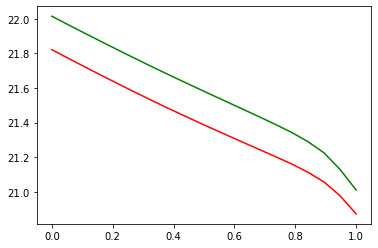

In [ ]:
import matplotlib.pyplot as plt
plt.plot(l1_ratio, train_loss, 'r-') # 빨간색 그래프는 학습 손실
plt.plot(l1_ratio, val_loss, 'g-')   # 초록색 그래프는 평가 손실
plt.show

##실험2: 로그변환의 영향력
- MinMaxScaler, StandardScaler, Log

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler



# MinMax

X_minmax = MinMaxScaler().fit_transform(X) # scaling
X_train, X_test, y_train, y_test  = train_test_split(X_minmax, y, test_size = 0.2)

model = ElasticNet(alpha=0.1, l1_ratio=0.8)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
val_pred = model.predict(X_test)

print("[MinMaxScaler]")
print(f'- 회귀 계수는 {model.coef_}')
print(f"- train set MSE : {mean_squared_error(y_train, train_pred)}")
print(f"- test  set MSE : {mean_squared_error(y_test, val_pred)}\n")

# StdScaler

X_std = StandardScaler().fit_transform(X) # 정규분포로
X_train, X_test, y_train, y_test  = train_test_split(X_std, y, test_size = 0.2)

model = ElasticNet(alpha=0.1, l1_ratio=0.8)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
val_pred = model.predict(X_test)

print("[StandardScaler]")
print(f'- 회귀 계수는 {model.coef_}')
print(f"- train set MSE : {mean_squared_error(y_train, train_pred)}")
print(f"- test  set MSE : {mean_squared_error(y_test, val_pred)}\n")

# Log Transformation

X_log = np.log1p(np.abs(X)) # 음수 피쳐가 있어 로그 변환시 NaN이 뜸. 일단 절대값 취해보자
X_train, X_test, y_train, y_test  = train_test_split(X_log, y, test_size = 0.2)

model = ElasticNet(alpha=0.1, l1_ratio=0.8)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
val_pred = model.predict(X_test)

print("[Log1p Transform]")
print(f'- 회귀 계수는 {model.coef_}')
print(f"- train set MSE : {mean_squared_error(y_train, train_pred)}")
print(f"- test  set MSE : {mean_squared_error(y_test, val_pred)}\n")

[MinMaxScaler]
- 회귀 계수는 [ 0.00000000e+00  0.00000000e+00 -8.62899648e+00  1.61144653e+01
 -1.25107291e+01 -0.00000000e+00  1.18086109e+01 -0.00000000e+00
  3.89692151e-03]
- train set MSE : 29.23676360719665
- test  set MSE : 28.970124142110006

[StandardScaler]
- 회귀 계수는 [-1.57707324  0.25400702 -3.30277225  4.27819343 -4.0611226  -0.36586784
  5.33542875 -0.          1.37311394]
- train set MSE : 20.955994671007282
- test  set MSE : 22.062169804731447

[Log1p Transform]
- 회귀 계수는 [-4.66065038  0.          7.43255992  7.95015307  1.38328812 -3.38626347
  3.22357158 -2.25004764 -0.46835853]
- train set MSE : 39.452689982353796
- test  set MSE : 37.33540450536017



In [ ]:
X_log.isna

<bound method DataFrame.isna of             u_q   coolant       u_d  ...   ambient    torque  profile_id
0     -0.599077  2.985943 -0.430867  ...  3.037387  0.171514    2.890372
1     -0.394135  2.986619 -0.364999  ...  3.037386  0.219471    2.890372
2     -0.581363  2.987134 -0.466016  ...  3.037385  0.162642    2.890372
3     -0.396048  2.987477 -0.380088  ...  3.037385  0.213742    2.890372
4     -0.637051  2.988558 -0.403875  ...  3.037385  0.189129    2.890372
...         ...       ...       ...  ...       ...       ...         ...
55952  3.358585  3.011078       NaN  ...  3.037202  4.599506    3.496508
55953  3.354777  3.014354       NaN  ...  3.037254  4.600172    3.496508
55954  3.355836  3.017208       NaN  ...  3.037291  4.599995    3.496508
55955  3.357246  3.019651       NaN  ...  3.037317  4.599841    3.496508
55956  3.357364  3.020228       NaN  ...  3.037336  4.599851    3.496508

[55957 rows x 9 columns]>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


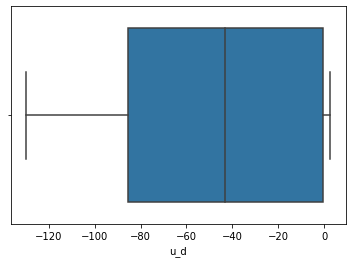

In [ ]:
# 음수 피쳐 분포 살펴보기

sns.boxplot(X.loc[:]['u_d'])

# loss만 봐서는 예측이 잘 되고 있는 건지 모르겠어서 예측을 시각화해보겠다

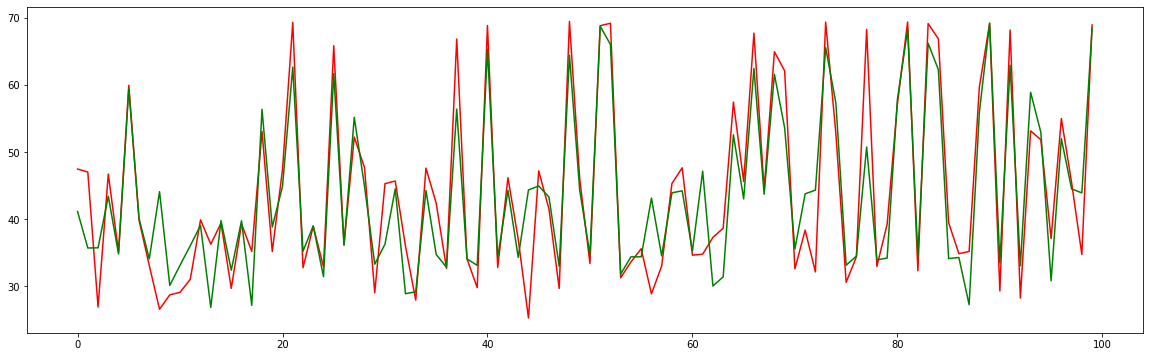

In [73]:

S = StandardScaler().fit(X)
X_scaled = S.transform(X)
X_train, X_test, y_train, y_test  = train_test_split(X_scaled, y, test_size = 0.2)

model = ElasticNet(alpha=a, l1_ratio=r)
model.fit(X_train, y_train)
val_pred = model.predict(X_test)

n = 100
plt.figure(figsize=(20, 6))
plt.plot(np.arange(0, n), y_test[:n], 'r')
plt.plot(np.arange(0, n), val_pred[:n], 'g')
plt.show()

In [65]:
print(train_pred[:20].shape)
print(val_pred[:20].shape)

(20,)
(20,)
